In [1]:
#TODO: put images into channels,
#the discriminator will distinguish between real and fake at a same time

import argparse
import os
import random
import torch as t
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision as tv
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 42
print("Random seed = ", manualSeed)
random.seed(manualSeed)
t.manual_seed(manualSeed)

Random seed =  42


In [3]:
dataroot = './data/celeba'
num_workers = 2
batch_size=8
image_size=64

nc = 3 #no. channels of images
nz = 100
ngf = 64 #no. generator's feature maps
ndf = 64 #no. discriminator's feature maps
num_epochs = 12
lr = .0002
beta1 = .5
ngpu = 1 #no. gpu


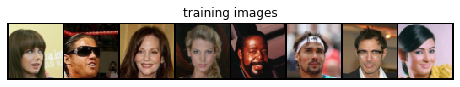

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

dataset = tv.datasets.ImageFolder(root=dataroot,
                                 transform=tv.transforms.Compose([
                                     tv.transforms.Resize(image_size), 
                                     tv.transforms.RandomHorizontalFlip(p=0.5),
                                     tv.transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),\
                                     tv.transforms.RandomAffine(0, scale=(.95, 1.2)), \
                                     tv.transforms.CenterCrop(image_size),
                                     tv.transforms.ToTensor(),
                                     tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5)), 
                                     AddGaussianNoise(.5, .05),
                                 ]))
dataset = tv.datasets.ImageFolder(root=dataroot,
                           transform=tv.transforms.Compose([
                               tv.transforms.Resize(image_size),
                               tv.transforms.CenterCrop(image_size),
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader2 = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader3 = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader4 = t.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

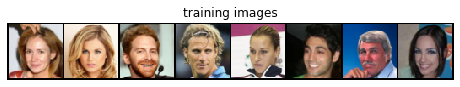

In [5]:
real_batch = next(iter(dataloader2))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

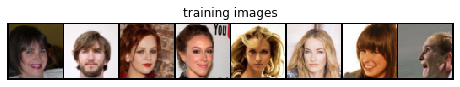

In [6]:
real_batch = next(iter(dataloader3))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

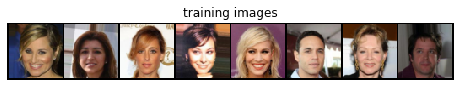

In [7]:
real_batch = next(iter(dataloader4))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [8]:
#now, init model weight according to normal distribution, why?
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        t.nn.init.normal_(m.weight.data, .0, .02)
    elif classname.find('BatchNorm')!= -1:
        t.nn.init.normal_(m.weight.data, 1.0, .02)
        t.nn.init.constant_(m.bias.data, 0.0)

In [9]:
class Generator(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.fc1 = t.nn.Linear(nz, nc * image_size * image_size)
        self.conv1 = t.nn.Conv2d( nc, ngf * 2, 7, stride=2, padding=1, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ngf * 2)        
        self.conv2 = t.nn.Conv2d( ngf * 2, ngf * 2, 3, stride=1, padding=1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ngf * 2)        
        self.conv3 = t.nn.Conv2d( ngf * 2, ngf * 2, 3, stride=1, padding=1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ngf * 2)
        self.conv4 = t.nn.Conv2d( ngf * 2, ngf * 2, 3, stride=1, padding=1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ngf * 2)
        self.conv5 = t.nn.Conv2d( ngf * 2, ngf * 4, 3, stride=2, padding=1, bias=False)
        self.bn5 = t.nn.BatchNorm2d(ngf * 4)
        self.conv6 = t.nn.Conv2d( ngf * 4, ngf * 8, 3, stride=2, padding=1, bias=False)
        self.bn6 = t.nn.BatchNorm2d(ngf * 8)
        self.conv7 = t.nn.Conv2d( ngf * 8, ngf * 16, 3, stride=2, padding=1, bias=False)
        self.bn7 = t.nn.BatchNorm2d(ngf * 16)
        self.conv8 = t.nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False)
        self.bn8 = t.nn.BatchNorm2d(ngf * 8)
        self.conv9 = t.nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn9 = t.nn.BatchNorm2d(ngf * 4)        
        self.conv10 = t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn10 = t.nn.BatchNorm2d(ngf * 2)
        self.conv11 = t.nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False)
        

    def forward(self, x):
#        print (x.shape)
        x = t.nn.functional.leaky_relu(self.fc1(x.squeeze()).view(-1, nc, image_size*1, image_size*1), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        #print (x.shape)
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        #print (x.shape)
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        #print (x.shape)
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        #print (x.shape)
        x = t.nn.functional.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.2)
        #print (x.shape)        
        x = t.nn.functional.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn7(self.conv7(x)), negative_slope=0.2) 
        x = t.nn.functional.leaky_relu(self.bn8(self.conv8(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn9(self.conv9(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn10(self.conv10(x)), negative_slope=0.2)        
        #print (x.shape)
        x = t.tanh(self.conv11(x))
        return x



class GeneratorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is Z, going into a convolution
            t.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            t.nn.BatchNorm2d(ngf * 8),
            t.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            t.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 4),
            t.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            t.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf * 2),
            t.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            t.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ngf),
            t.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            t.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            t.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netg = Generator(ngpu).to(device)
if (device.type=='cuda') and (ngpu > 1):
    netg = t.nn.DataParallel(netg, list(range(ngpu)))
netg.apply(weight_init)  #apply weight_init recursively to all children
print(netg)

Generator(
  (fc1): Linear(in_features=100, out_features=12288, bias=True)
  (conv1): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256,

In [11]:
for item in netg.children():
    for item2 in item.children():
        print (item2.__class__.__name__)


In [12]:

class Discriminator(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1a = t.nn.Conv2d(nc * 2 , ndf * 2, 7, 2, 1, bias=False)
        self.bn1a = t.nn.BatchNorm2d(ndf * 2)
        self.conv1b = t.nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn1b = t.nn.BatchNorm2d(ndf * 2)
        self.conv1c = t.nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn1c = t.nn.BatchNorm2d(ndf * 2)
        self.conv1d = t.nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn1d = t.nn.BatchNorm2d(ndf * 2)
        self.conv1e = t.nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False)
        self.bn1e = t.nn.BatchNorm2d(ndf * 2)        
        self.conv2a = t.nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)
        self.bn2a = t.nn.BatchNorm2d(ndf * 4)
        self.res2a  = t.nn.Conv2d(ndf * 2, ndf * 4, 1, 2, 0, bias=False)
        self.res2a_bn = t.nn.BatchNorm2d(ndf * 4)
        self.conv2b = t.nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 1, bias=False)
        self.bn2b = t.nn.BatchNorm2d(ndf * 4)
        self.conv2c = t.nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 1, bias=False)
        self.bn2c = t.nn.BatchNorm2d(ndf * 4) 
        self.conv3 = t.nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ndf * 8)
        self.res3  = t.nn.Conv2d(ndf * 4, ndf * 8, 1, 2, 0, bias=False)
        self.res3_bn = t.nn.BatchNorm2d(ndf * 8)        
        self.conv4 = t.nn.Conv2d(ndf * 8, ndf * 16, 3, 2, 2, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ndf * 16)
        #self.conv5 = t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        self.aapool1 = t.nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = t.nn.Linear(ndf * 16, 1)

    def forward(self, x1, x2):#(self, x1, x2, x3, x4):
        #print (x1.shape, x2.shape)
        #x = t.cat((x1, x2, x3, x4), dim=1)
        x = t.cat((x1, x2), dim=1)
        x = t.nn.functional.leaky_relu(self.bn1a(self.conv1a(x)), negative_slope=0.2)
        res = x
        x = t.nn.functional.leaky_relu(self.bn1b(self.conv1b(x)), negative_slope=0.2)
        x = x + res
        res = x
        x = t.nn.functional.leaky_relu(self.bn1c(self.conv1c(x)), negative_slope=0.2)
        x = x + res
        res = x
        x = t.nn.functional.leaky_relu(self.bn1d(self.conv1d(x)), negative_slope=0.2)
        x = x + res
        res = x        
        x = t.nn.functional.leaky_relu(self.bn1e(self.conv1e(x)), negative_slope=0.2)
        x = x + res
        res = self.res2a_bn(self.res2a(x))
        x = t.nn.functional.leaky_relu(self.bn2a(self.conv2a(x)), negative_slope=0.2)
        #print (x.shape, res.shape)
        x = x + res
        res = x
        x = t.nn.functional.leaky_relu(self.bn2b(self.conv2b(x)), negative_slope=0.2)
        x = x + res
        res = x
        x = t.nn.functional.leaky_relu(self.bn2c(self.conv2c(x)), negative_slope=0.2)
        x = x + res
        res = self.res3_bn(self.res3(x))
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x + res
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = self.aapool1(x).squeeze()
        x = t.sigmoid(self.fc1(x))
        return x

class DiscriminatorV1(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1 = t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.bn1 = t.nn.BatchNorm2d(ndf * 1)
        self.conv2 = t.nn.Conv2d(ndf * 1, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = t.nn.BatchNorm2d(ndf * 2)
        self.conv3 = t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = t.nn.BatchNorm2d(ndf * 4)
        self.conv4 = t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = t.nn.BatchNorm2d(ndf * 8)
        self.conv5 = t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = t.nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = t.nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = t.sigmoid(self.conv5(x))
        return x

class DiscriminatorV0(t.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = t.nn.Sequential(
            # input is (nc) x 64 x 64
            t.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            t.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 2),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            t.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 4),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            t.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            t.nn.BatchNorm2d(ndf * 8),
            t.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            t.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            t.nn.S ()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
netd = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netd = t.nn.DataParallel(netd, list(range(ngpu)))
netd.apply(weight_init)
print(netd)

Discriminator(
  (conv1a): Conv2d(6, 128, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1c): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1c): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1e): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1e): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2a): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=

In [14]:

criterion = t.nn.BCELoss()
#criterion = t.nn.BCEWithLogitsLoss()

fixed_noise = t.randn(64, nz, 1, 1, device=device)
#fixed_noise = create_noise(nz)

label_real = 1
label_fake = 0

optimizer_d = optim.Adam(netd.parameters(), lr=lr, betas=(beta1, .999))
optimizer_g = optim.Adam(netg.parameters(), lr=lr, betas=(beta1, .999))


In [15]:
img_list = []
g_loss = []
d_loss = []
iters = 0

print ('Start training')

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netd.zero_grad()
        
        #train d
        #train d with all read data batch
        real_cpu = data[0].to(device)
        real_cpu2 = next(iter(dataloader2))[0].to(device)
        #real_cpu3 = next(iter(dataloader3))[0].to(device)
        #real_cpu4 = next(iter(dataloader4))[0].to(device)
        
        
        b_size = real_cpu.size(0)
        label = t.full((b_size,), label_real, dtype=t.float, device=device) #create a vector [label_real, ...] equal to batch size
        b_min = np.min((real_cpu.size(0), real_cpu2.size(0)))
        output = netd(real_cpu[:b_min], real_cpu2[:b_min]).view(-1)
        err_d_real = criterion(output, label[:b_min])
        err_d_real.backward()
        D_x = output.mean().item() #why mean here? mean over all batch values?
        #train d with fake data from g
        noise = t.randn(b_size, nz, 1, 1, device=device)
        fake = netg(noise)
        label.fill_(label_fake) #change the gt label, no be [label_fake, ...] instead
        output = netd(real_cpu[:b_min], fake[:b_min].detach()).view(-1)
        err_d_fake = criterion(output, label)
        err_d_fake.backward()
        D_G_z1 = output.mean().item() #D(G(z)) over batch of z
        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()
        
        #train g: minimize 1 - D(G(z)) is maximize (D(G(z)))
        netg.zero_grad()
        label.fill_(label_real)
        output=netd(real_cpu[:b_min], fake[:b_min]).view(-1)
        err_g = criterion(output, label)
        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()
        
        if i%50 == 0:
            print (f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] \t Loss_D: {err_d.item():.4f}, Loss_G: {err_g.item():.4f} \t D(x): {D_x} \t D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        
        g_loss.append(err_g.item())
        d_loss.append(err_d.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with t.no_grad():
                fake = netg(fixed_noise).detach().cpu()
            img_list.append(tv.utils.make_grid(fake, padding=2, normalize=True))    
            
        iters += 1#fine grain iteration 

Start training
[0/12][0/25325] 	 Loss_D: 1.3893, Loss_G: 0.8006 	 D(x): 0.5099387764930725 	 D(G(z)): 0.5101 / 0.4496
[0/12][50/25325] 	 Loss_D: 1.3286, Loss_G: 0.8207 	 D(x): 0.519606351852417 	 D(G(z)): 0.4846 / 0.4413
[0/12][100/25325] 	 Loss_D: 1.3371, Loss_G: 0.8053 	 D(x): 0.5075399875640869 	 D(G(z)): 0.4761 / 0.4492
[0/12][150/25325] 	 Loss_D: 1.3905, Loss_G: 0.7773 	 D(x): 0.5013818740844727 	 D(G(z)): 0.4998 / 0.4610
[0/12][200/25325] 	 Loss_D: 1.3373, Loss_G: 0.7687 	 D(x): 0.5252189636230469 	 D(G(z)): 0.4972 / 0.4642
[0/12][250/25325] 	 Loss_D: 1.3308, Loss_G: 0.8225 	 D(x): 0.5222764015197754 	 D(G(z)): 0.4907 / 0.4409
[0/12][300/25325] 	 Loss_D: 1.2806, Loss_G: 0.8316 	 D(x): 0.5299999117851257 	 D(G(z)): 0.4720 / 0.4369
[0/12][350/25325] 	 Loss_D: 1.3126, Loss_G: 0.8279 	 D(x): 0.533199667930603 	 D(G(z)): 0.4906 / 0.4394
[0/12][400/25325] 	 Loss_D: 1.2562, Loss_G: 0.8605 	 D(x): 0.5570898056030273 	 D(G(z)): 0.4846 / 0.4247
[0/12][450/25325] 	 Loss_D: 1.2625, Loss_G: 0

[0/12][3900/25325] 	 Loss_D: 0.8504, Loss_G: 2.1288 	 D(x): 0.4847632050514221 	 D(G(z)): 0.0681 / 0.1291
[0/12][3950/25325] 	 Loss_D: 0.3301, Loss_G: 3.0851 	 D(x): 0.7799532413482666 	 D(G(z)): 0.0675 / 0.0470
[0/12][4000/25325] 	 Loss_D: 0.6235, Loss_G: 2.5430 	 D(x): 0.7629632949829102 	 D(G(z)): 0.2902 / 0.0824
[0/12][4050/25325] 	 Loss_D: 1.0897, Loss_G: 0.2900 	 D(x): 0.3784642219543457 	 D(G(z)): 0.0946 / 0.7511
[0/12][4100/25325] 	 Loss_D: 0.4444, Loss_G: 1.8813 	 D(x): 0.8207895755767822 	 D(G(z)): 0.2117 / 0.1582
[0/12][4150/25325] 	 Loss_D: 0.4193, Loss_G: 2.9241 	 D(x): 0.7414965629577637 	 D(G(z)): 0.1075 / 0.0560
[0/12][4200/25325] 	 Loss_D: 0.6677, Loss_G: 1.7099 	 D(x): 0.5767651200294495 	 D(G(z)): 0.0998 / 0.1878
[0/12][4250/25325] 	 Loss_D: 0.3915, Loss_G: 2.9619 	 D(x): 0.8827943801879883 	 D(G(z)): 0.2312 / 0.0524
[0/12][4300/25325] 	 Loss_D: 0.5649, Loss_G: 2.4216 	 D(x): 0.6163629293441772 	 D(G(z)): 0.0628 / 0.0958
[0/12][4350/25325] 	 Loss_D: 0.4402, Loss_G: 2

[0/12][7800/25325] 	 Loss_D: 0.2388, Loss_G: 2.4617 	 D(x): 0.85821533203125 	 D(G(z)): 0.0741 / 0.1033
[0/12][7850/25325] 	 Loss_D: 0.5837, Loss_G: 3.0788 	 D(x): 0.9507367610931396 	 D(G(z)): 0.3982 / 0.0504
[0/12][7900/25325] 	 Loss_D: 2.2439, Loss_G: 0.3179 	 D(x): 0.12394911050796509 	 D(G(z)): 0.0819 / 0.7355
[0/12][7950/25325] 	 Loss_D: 0.2664, Loss_G: 3.3324 	 D(x): 0.939911425113678 	 D(G(z)): 0.1816 / 0.0378
[0/12][8000/25325] 	 Loss_D: 0.4067, Loss_G: 2.9583 	 D(x): 0.9583865404129028 	 D(G(z)): 0.2961 / 0.0550
[0/12][8050/25325] 	 Loss_D: 1.1984, Loss_G: 4.0326 	 D(x): 0.9168726205825806 	 D(G(z)): 0.6344 / 0.0192
[0/12][8100/25325] 	 Loss_D: 0.3552, Loss_G: 4.4413 	 D(x): 0.7309054732322693 	 D(G(z)): 0.0190 / 0.0138
[0/12][8150/25325] 	 Loss_D: 0.1113, Loss_G: 2.8927 	 D(x): 0.9855663180351257 	 D(G(z)): 0.0918 / 0.0578
[0/12][8200/25325] 	 Loss_D: 0.4833, Loss_G: 3.5122 	 D(x): 0.745202362537384 	 D(G(z)): 0.1637 / 0.0330
[0/12][8250/25325] 	 Loss_D: 1.3175, Loss_G: 2.72

[0/12][11700/25325] 	 Loss_D: 0.3141, Loss_G: 2.7648 	 D(x): 0.799200177192688 	 D(G(z)): 0.0743 / 0.0652
[0/12][11750/25325] 	 Loss_D: 0.3337, Loss_G: 2.9664 	 D(x): 0.9815444946289062 	 D(G(z)): 0.2572 / 0.0556
[0/12][11800/25325] 	 Loss_D: 0.4692, Loss_G: 2.2874 	 D(x): 0.7531940937042236 	 D(G(z)): 0.1595 / 0.1035
[0/12][11850/25325] 	 Loss_D: 0.2214, Loss_G: 2.7302 	 D(x): 0.9618558883666992 	 D(G(z)): 0.1643 / 0.0684
[0/12][11900/25325] 	 Loss_D: 0.6898, Loss_G: 3.0832 	 D(x): 0.5143809914588928 	 D(G(z)): 0.0209 / 0.0508
[0/12][11950/25325] 	 Loss_D: 0.4148, Loss_G: 2.9280 	 D(x): 0.6909582614898682 	 D(G(z)): 0.0301 / 0.0638
[0/12][12000/25325] 	 Loss_D: 0.1440, Loss_G: 4.4570 	 D(x): 0.900868833065033 	 D(G(z)): 0.0376 / 0.0122
[0/12][12050/25325] 	 Loss_D: 0.6280, Loss_G: 3.3560 	 D(x): 0.7300187945365906 	 D(G(z)): 0.2356 / 0.0379
[0/12][12100/25325] 	 Loss_D: 0.3267, Loss_G: 2.9175 	 D(x): 0.875804603099823 	 D(G(z)): 0.1710 / 0.0569
[0/12][12150/25325] 	 Loss_D: 0.5360, Lo

[0/12][15550/25325] 	 Loss_D: 0.2855, Loss_G: 3.5352 	 D(x): 0.9651526212692261 	 D(G(z)): 0.2184 / 0.0311
[0/12][15600/25325] 	 Loss_D: 0.0866, Loss_G: 3.0745 	 D(x): 0.9729799032211304 	 D(G(z)): 0.0571 / 0.0499
[0/12][15650/25325] 	 Loss_D: 0.3018, Loss_G: 3.1234 	 D(x): 0.7819922566413879 	 D(G(z)): 0.0425 / 0.0587
[0/12][15700/25325] 	 Loss_D: 0.7246, Loss_G: 2.0247 	 D(x): 0.7351350784301758 	 D(G(z)): 0.3296 / 0.1341
[0/12][15750/25325] 	 Loss_D: 0.6486, Loss_G: 5.2262 	 D(x): 0.9922752380371094 	 D(G(z)): 0.4496 / 0.0058
[0/12][15800/25325] 	 Loss_D: 0.1979, Loss_G: 4.0790 	 D(x): 0.8947240114212036 	 D(G(z)): 0.0811 / 0.0174
[0/12][15850/25325] 	 Loss_D: 0.3478, Loss_G: 3.7223 	 D(x): 0.9188124537467957 	 D(G(z)): 0.2254 / 0.0248
[0/12][15900/25325] 	 Loss_D: 0.4497, Loss_G: 3.3012 	 D(x): 0.8922827243804932 	 D(G(z)): 0.2729 / 0.0461
[0/12][15950/25325] 	 Loss_D: 0.4861, Loss_G: 2.3278 	 D(x): 0.7393977642059326 	 D(G(z)): 0.1459 / 0.0997
[0/12][16000/25325] 	 Loss_D: 0.4448,

[0/12][19400/25325] 	 Loss_D: 0.3981, Loss_G: 3.0358 	 D(x): 0.9667667746543884 	 D(G(z)): 0.2952 / 0.0510
[0/12][19450/25325] 	 Loss_D: 0.4840, Loss_G: 3.3267 	 D(x): 0.9753472805023193 	 D(G(z)): 0.3475 / 0.0366
[0/12][19500/25325] 	 Loss_D: 0.7811, Loss_G: 4.7012 	 D(x): 0.513299822807312 	 D(G(z)): 0.0060 / 0.0109
[0/12][19550/25325] 	 Loss_D: 1.6033, Loss_G: 3.7418 	 D(x): 0.9799877405166626 	 D(G(z)): 0.7629 / 0.0257
[0/12][19600/25325] 	 Loss_D: 0.4263, Loss_G: 2.6549 	 D(x): 0.9643234014511108 	 D(G(z)): 0.3147 / 0.0726
[0/12][19650/25325] 	 Loss_D: 0.5459, Loss_G: 4.4472 	 D(x): 0.9597735404968262 	 D(G(z)): 0.3839 / 0.0120
[0/12][19700/25325] 	 Loss_D: 0.5779, Loss_G: 2.4124 	 D(x): 0.8783259987831116 	 D(G(z)): 0.3496 / 0.0939
[0/12][19750/25325] 	 Loss_D: 0.3168, Loss_G: 4.2910 	 D(x): 0.9148619174957275 	 D(G(z)): 0.1938 / 0.0146
[0/12][19800/25325] 	 Loss_D: 1.2554, Loss_G: 2.6534 	 D(x): 0.8271977305412292 	 D(G(z)): 0.6152 / 0.0804
[0/12][19850/25325] 	 Loss_D: 1.1535, 

[0/12][23250/25325] 	 Loss_D: 0.4457, Loss_G: 2.4717 	 D(x): 0.7202593088150024 	 D(G(z)): 0.0942 / 0.0880
[0/12][23300/25325] 	 Loss_D: 0.8345, Loss_G: 3.9954 	 D(x): 0.9586275815963745 	 D(G(z)): 0.5400 / 0.0196
[0/12][23350/25325] 	 Loss_D: 0.7642, Loss_G: 2.6901 	 D(x): 0.6778197288513184 	 D(G(z)): 0.2644 / 0.0900
[0/12][23400/25325] 	 Loss_D: 0.4639, Loss_G: 2.7794 	 D(x): 0.6930180788040161 	 D(G(z)): 0.0676 / 0.0668
[0/12][23450/25325] 	 Loss_D: 0.0931, Loss_G: 3.7465 	 D(x): 0.9467496871948242 	 D(G(z)): 0.0366 / 0.0278
[0/12][23500/25325] 	 Loss_D: 0.2871, Loss_G: 2.5656 	 D(x): 0.9267313480377197 	 D(G(z)): 0.1830 / 0.0831
[0/12][23550/25325] 	 Loss_D: 0.3617, Loss_G: 2.9221 	 D(x): 0.7745317220687866 	 D(G(z)): 0.0914 / 0.0623
[0/12][23600/25325] 	 Loss_D: 0.8718, Loss_G: 3.0490 	 D(x): 0.9034723043441772 	 D(G(z)): 0.5140 / 0.0562
[0/12][23650/25325] 	 Loss_D: 0.2104, Loss_G: 3.7416 	 D(x): 0.922215461730957 	 D(G(z)): 0.1198 / 0.0256
[0/12][23700/25325] 	 Loss_D: 0.2562, 

[1/12][1800/25325] 	 Loss_D: 0.6949, Loss_G: 3.6103 	 D(x): 0.6039624214172363 	 D(G(z)): 0.0662 / 0.0335
[1/12][1850/25325] 	 Loss_D: 0.1953, Loss_G: 3.1444 	 D(x): 0.9624752998352051 	 D(G(z)): 0.1449 / 0.0436
[1/12][1900/25325] 	 Loss_D: 0.8550, Loss_G: 2.1438 	 D(x): 0.6736652255058289 	 D(G(z)): 0.3277 / 0.1301
[1/12][1950/25325] 	 Loss_D: 0.5251, Loss_G: 3.6287 	 D(x): 0.917060136795044 	 D(G(z)): 0.3517 / 0.0281
[1/12][2000/25325] 	 Loss_D: 0.8753, Loss_G: 3.1153 	 D(x): 0.8107089996337891 	 D(G(z)): 0.4712 / 0.0479
[1/12][2050/25325] 	 Loss_D: 0.5924, Loss_G: 2.0928 	 D(x): 0.6557654738426208 	 D(G(z)): 0.1416 / 0.1362
[1/12][2100/25325] 	 Loss_D: 0.3450, Loss_G: 2.9790 	 D(x): 0.7576980590820312 	 D(G(z)): 0.0589 / 0.0537
[1/12][2150/25325] 	 Loss_D: 0.5066, Loss_G: 3.0521 	 D(x): 0.7075053453445435 	 D(G(z)): 0.1342 / 0.0498
[1/12][2200/25325] 	 Loss_D: 0.3816, Loss_G: 1.7075 	 D(x): 0.8979966640472412 	 D(G(z)): 0.2258 / 0.1869
[1/12][2250/25325] 	 Loss_D: 0.7420, Loss_G: 2.

[1/12][5700/25325] 	 Loss_D: 0.4455, Loss_G: 3.8331 	 D(x): 0.9831576347351074 	 D(G(z)): 0.3266 / 0.0238
[1/12][5750/25325] 	 Loss_D: 0.4661, Loss_G: 1.9836 	 D(x): 0.7772676348686218 	 D(G(z)): 0.1762 / 0.1526
[1/12][5800/25325] 	 Loss_D: 0.6196, Loss_G: 3.4880 	 D(x): 0.6071635484695435 	 D(G(z)): 0.0709 / 0.0341
[1/12][5850/25325] 	 Loss_D: 0.7432, Loss_G: 3.9669 	 D(x): 0.9532451629638672 	 D(G(z)): 0.4515 / 0.0269
[1/12][5900/25325] 	 Loss_D: 0.9821, Loss_G: 2.8535 	 D(x): 0.5905640125274658 	 D(G(z)): 0.3458 / 0.0681
[1/12][5950/25325] 	 Loss_D: 1.8226, Loss_G: 2.5336 	 D(x): 0.7670644521713257 	 D(G(z)): 0.7647 / 0.0880
[1/12][6000/25325] 	 Loss_D: 0.5106, Loss_G: 2.8418 	 D(x): 0.7937768697738647 	 D(G(z)): 0.2258 / 0.0658
[1/12][6050/25325] 	 Loss_D: 0.3887, Loss_G: 2.6362 	 D(x): 0.971775472164154 	 D(G(z)): 0.2911 / 0.0765
[1/12][6100/25325] 	 Loss_D: 0.6019, Loss_G: 1.8096 	 D(x): 0.830763578414917 	 D(G(z)): 0.3283 / 0.1838
[1/12][6150/25325] 	 Loss_D: 1.4381, Loss_G: 1.4

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6446a85560>
Traceback (most recent call last):
  File "/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 24448, 24449) exited unexpectedly

In [16]:
real_cpu.shape, real_cpu2.shape, real_cpu3.shape, real_cpu4.shape, fake.shape


NameError: name 'real_cpu3' is not defined

In [17]:
output.shape, label[:b_min].shape

(torch.Size([8]), torch.Size([8]))

In [18]:
noise.shape, netg(noise).shape

(torch.Size([8, 100, 1, 1]), torch.Size([8, 3, 64, 64]))

In [19]:
b_size

8

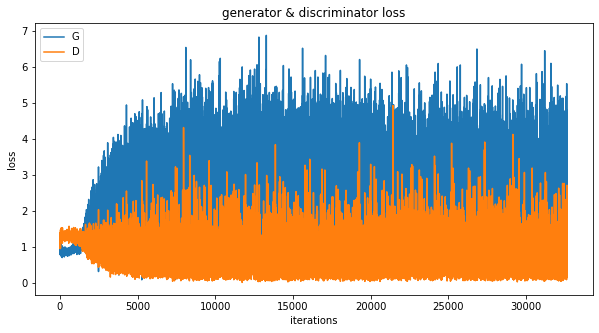

In [20]:
plt.figure(figsize=(10, 5))
plt.title('generator & discriminator loss')
plt.plot(g_loss, label='G')
plt.plot(d_loss, label='D')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()


In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

fig = plt.figure(figsize=(8,8))
plt.axis("off")
plt.tight_layout()
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('real images')
plt.imshow(np.transpose(tv.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('fake images')
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))


In [ ]:
output.shape, label.shape, real_cpu.shape